# <font color="#5fa8d3"> Claim Costs

## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Syntetic Dataset](#id1)<br>
    1.1 [Miscellaneous Damage - lost parts (mis_lost)](#id11)<br>
    1.2 [Metal damage tear - torn (met_tear)](#id12)<br>
    1.3 [Metal damage scratches - paint scratches (met_scratch)](#id13)<br>
    1.4 [Glass damage crack - broken glass (glass_crack)](#id14)<br>
    1.5 [Miscellaneous Damage - puncture (mis_punct)](#id15)<br>
    1.6 [Miscellaneous Damage - broken lamp (mis_lamp)](#id16)<br>
    1.7 [Metal damage dent - minor dented (met_dent_minor)](#id17)<br>
    1.8 [Metal damage dent - medium dented (met_dent_medium)](#id18)<br>
    1.9 [Metal damage dent - severe dented (met_dent_severe)](#id19)<br>
    1.10 [Total Cost Dataset](#id110)<br>
2. [Cost Model](#id2)<br>

## <font color="#62b6cb"> 0. Libraries Importation & Funtions Definition <a name="id0"></a>

**Libraries Importation**

In [218]:
import json # to import jsons
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting nicer
from scipy.stats import gamma
import yaml # for importing a yaml file

**Configuration Variables**

In [225]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed_def: 123


We set the seed for reproducibility

In [223]:
np.random.seed(seed)

**Count Category Occurrences Function**

In [214]:
def count_category_occurrences(coco_json_path):
    """
    Count the number of times of each oft he categories of a Coco format appears in the annotations part

    Args:
        coco_jso _path (str): path of the annotations file.


    Outputs:
        category_counts (dict) : dictionary with the name of the categories and the number of times that appears each one.
    """
    # Leer el archivo JSON
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Crear un diccionario para mapear ids de categorías a nombres
    category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
    
    # Inicializar un diccionario para contar las apariciones de cada categoría
    category_counts = {category['name']: 0 for category in coco_data['categories']}
    
    # Contar las apariciones de cada categoría en las anotaciones
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = category_id_to_name[category_id]
        category_counts[category_name] += 1
    
    return category_counts

**Truncated Gamma Function**

We create the truncated gamma function for modelling the different damage types claims:

In [195]:
def truncated_gamma(shape, scale, lower, upper, size):
    """
    Generates samples from a truncated gamma distribution within specified bounds.

    Parameters:
    shape (float): The shape parameter of the gamma distribution.
    scale (float): The scale parameter of the gamma distribution.
    lower (float): The lower bound for truncation.
    upper (float): The upper bound for truncation.
    size (int): The number of samples to generate.

    Returns:
    np.ndarray: An array of samples from the truncated gamma distribution.
    """
    samples = []
    while len(samples) < size:
        sample = gamma(shape, scale=scale).rvs(size)
        sample = sample[(sample >= lower) & (sample <= upper)]
        samples.extend(sample)
    return np.array(samples[:size])

**Exponential Function for Labour Cost**

In [197]:
def exponential_dist(lmbda, size=1,ini=0.5):
    """
    Simulates an exponential distribution with a specified lambda value and initial offset.

    Parameters:
    lmbda (float): The rate parameter (lambda) of the exponential distribution.
    size (int): The number of samples to generate. Default is 1.
    ini (float): An initial offset added to each sample. Default is 0.5.

    Returns:
    np.ndarray: An array of samples from the exponential distribution with the initial offset applied.
    """
    return ini+np.random.exponential(1/lmbda, size)

**Damage Type Montecarlo Simulation Function**

In [198]:
def simulate_data(n=5000, damage_type="glass_crack", low_trunc=100, high_trunc=400,
                  brands={"Toyota": 1, "Volkswagen": 1.25},
                  models={"Yaris": 0.75, "Corolla": 1, "C-HR": 1.20, "Polo": 0.73, "Golf": 1, "Tiguan": 1.45},
                  model_brand={"Yaris": "Toyota", "Corolla": "Toyota", "C-HR": "Toyota", "Polo": "Volkswagen", "Golf": "Volkswagen", "Tiguan": "Volkswagen"},
                  age_range={"Newer": 0.8, "Middle": 1, "Old": 0.5},
                  model_effect=1,
                  age_effect=1):
    """
    Simulates repair cost data for various car brands and models, considering different vehicle age ranges.

    Parameters:
    n (int): The number of samples to generate for each combination of brand, model, and age range.
    damage_type (str): The type of damage being simulated.
    low_trunc (float): The lower bound for truncating the gamma distribution.
    high_trunc (float): The upper bound for truncating the gamma distribution.
    brands (dict): A dictionary with car brands as keys and brand-specific multipliers as values.
    models (dict): A dictionary with car models as keys and model-specific multipliers as values.
    model_brand (dict): A dictionary mapping each model to its corresponding brand.
    age_range (dict): A dictionary with age ranges as keys and their specific multipliers as values.
    model_effect (float): A multiplier applied to the model-specific cost.
    age_effect (float): A multiplier applied to the age-specific cost.

    Returns:
    DataFrame: A DataFrame containing the simulated data with columns for brand, model, vehicle age, age range, damage type, and cost.
    """

    gamma_shape_base = 1.5
    gamma_scale_base = 100
    
    df_combined = pd.DataFrame()
    
    for brand, brand_multiplier in brands.items():
        for model, model_multiplier in models.items():
            if model_brand[model] != brand:
                continue
            
            # Lower age case
            veh_age_lower = np.random.randint(0, 8, size=n)  # 0 to 7
            cost_lower = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Newer"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Newer"] * age_effect,
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Newer"] * age_effect,
                n)
            
            # Base case
            veh_age_base = np.random.randint(7, 11, size=n)  # 7 to 10
            cost_base = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Middle"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Middle"],
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Middle"],
                n)
            
            # Higher age case
            veh_age_higher = np.random.randint(10, 16, size=n)  # 10 to 15
            cost_higher = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Old"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Old"] * age_effect,
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Old"] * age_effect,
                n)
            
            # Create DataFrames
            df_lower = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_lower,
                "veh_age_range": "Newer",
                "damage_type": [damage_type] * n,
                "cost": cost_lower
            })

            df_base = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_base,
                "veh_age_range": "Middle",
                "damage_type": [damage_type] * n,
                "cost": cost_base
            })
        
            df_higher = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_higher,
                "veh_age_range": "Old",
                "damage_type": [damage_type] * n,
                "cost": cost_higher
            })
            
            # Combine DataFrames for the current model
            df_model_combined = pd.concat([df_lower, df_base, df_higher], ignore_index=True)
            df_combined = pd.concat([df_combined, df_model_combined], ignore_index=True)
    
    # Shuffle the combined DataFrame
    df_combined = df_combined.sample(frac=1).reset_index(drop=True)
    
    return df_combined

**Labour Cost Montecarlo Simulation Function**

In [201]:
def simulate_labour(n=90000, lmbda=2, ini=0.5):
    """
    Simulates labour costs for a given number of simulations and lambda value.

    Parameters:
    n (int): The number of simulations to run. Default is 90,000.
    lmbda (float): The rate parameter (lambda) of the exponential distribution for hours worked. Default is 2.
    ini (float): An initial offset added to each sample of hours worked. As such, the minimum is half an hour. Default is 0.5.

    Returns:
    DataFrame: A DataFrame containing the simulated data with columns for average labour cost per hour,
               workshop factors, workshop quality, county factors, counties, labour costs, number of hours worked and total labour costs.
    """

    # Simulate the number of hours worked
    num_hours = exponential_dist(lmbda, size=n, ini=ini)

    # Simulate the workshop quality factor
    workshop_quality = np.random.choice(list(workshop_qlty_factor.keys()), size=n, p=list(workshop_qlty_dist.values()))
    workshop_factors = np.array([workshop_qlty_factor[quality] for quality in workshop_quality])

    # Simulate the county factor
    counties = np.random.choice(county_info['County'], size=n, p=county_info['prob_dist']/100)
    county_factors = county_info.set_index('County').loc[counties, 'factor'].values

    # Calculate the labour cost
    labour_costs = av_lab_ph * workshop_factors * county_factors
    total_labour_costs = labour_costs * num_hours

    # Create a DataFrame with all the traces
    df_labour = pd.DataFrame({
        'av_labour_per_hour': av_lab_ph,
        'workshop_factors': workshop_factors,
        'workshop_quality': workshop_quality,
        'county_factors': county_factors,
        'counties': counties,
        'labour_costs': labour_costs,
        'num_hours': num_hours,
        'total_labour_costs': total_labour_costs
    })

    return df_labour

**Cost Type Simulation Analysis Function**

In [207]:
def cost_analysis(df_combined, models, 
                  model_brand={"Yaris": "Toyota", "Corolla": "Toyota", "C-HR": "Toyota", "Polo": "Volkswagen", "Golf": "Volkswagen", "Tiguan": "Volkswagen"}, 
                  age=["Newer","Middle","Old"],
                  model_palette={"Yaris": "blue","Corolla": "green","C-HR": "red","Polo": "blue",
                                "Golf": "green","Tiguan": "red"}):
    """
    Analyzes and visualizes cost data across different vehicle models, brands, and age ranges.

    This function performs the following tasks:
    1. Plots density (including KDE - Kernel Density Estimate) and histogram of costs by vehicle age range for each model, for both Toyota and Volkswagen brands.
    2. Prints summary statistics of costs, grouped by vehicle age range, model, and brand.

    Parameters:
    df_combined (DataFrame): The combined DataFrame containing cost data for various car brands, models, and vehicle age ranges.
    models (dict): A dictionary with car models as keys and model-specific multipliers as values.
    model_brand (dict): A dictionary mapping each model to its corresponding brand. Default maps some Toyota and Volkswagen models.
    age (list): A list of age ranges to consider. Default is ["Newer", "Middle", "Old"].
    model_palette (dict): A dictionary mapping each model to its color for plotting. Default assigns colors to some Toyota and Volkswagen models.

    Returns:
    None
    """
    
    # Set the dark theme
    sns.set_theme(style="dark")
    
    # Define a custom color palette
    palette = model_palette
    
    # Plot density of cost with histogram by veh_age_range for each model
    ordered_models = sorted(models.items(), key=lambda item: item[1])
    
    for age_type in age:
        fig, axes = plt.subplots(1, 2, figsize=(19, 5), sharey=True)
        
        for i, brand in enumerate(["Toyota", "Volkswagen"]):
            ax = axes[i]
            brand_models = [model for model in models if model_brand[model] == brand]
            
            # Plot the histogram
            sns.histplot(
                df_combined[(df_combined['veh_age_range'] == age_type) & (df_combined['brand'] == brand)],
                x="cost", hue="model", bins=50, edgecolor='black', palette=palette, ax=ax,
                stat="density", common_norm=False
            )
            
            # Add KDE plots with thicker lines
            for model in brand_models:
                sns.kdeplot(
                    df_combined[(df_combined['veh_age_range'] == age_type) & (df_combined['brand'] == brand) & (df_combined['model'] == model)]['cost'],
                    ax=ax, linewidth=3, label=model, color=palette[model]
                )
            
            ax.set_title(f'Density Plot and Histogram of Cost by Vehicle Age Range for {brand} - {age_type}')
            ax.set_xlabel('Cost')
            ax.set_ylabel('Density')
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics of cost by veh_age_range, model, and brand
    summary_stats = df_combined.groupby(['brand', 'model', 'veh_age_range'])['cost'].describe().drop(columns='count').round(0).astype(int)
    
    # Reorder the index based on the desired order
    summary_stats = summary_stats.reindex([("Toyota", model, age_type) for model in model_brand if model_brand[model] == "Toyota" for age_type in age] +
                                          [("Volkswagen", model, age_type) for model in model_brand if model_brand[model] == "Volkswagen" for age_type in age])
    
    # Print the formatted and ordered summary statistics
    print("Summary statistics by brand, model, and vehicle age range:")
    print(summary_stats)

**Labour Simulation Analysis Function**

In [205]:
# Adjust the theoretical distribution to account for the initial shift
def shifted_exponential_pdf(x, lmbda, shift=0.5):
    """PDF of the shifted exponential distribution."""
    return lmbda * np.exp(-lmbda * (x - shift)) * (x >= shift)

def labour_analysis(df_labour, lmbda,ini=0.5):

    """
    Analyzes and plots various aspects of simulated labour cost data.

    This function performs several tasks:
    1. Prints summary statistics for the number of hours worked, labour costs, and total labour costs.
    2. Plots the observed distribution of hours worked against the theoretical shifted exponential distribution.
    3. Plots the distribution of labour costs per hour.
    4. Plots the distribution of total labour costs.
    5. Compares the real and simulated distribution of counties.
    6. Compares the real and simulated distribution of workshop quality.

    Parameters:
    df_labour (DataFrame): The DataFrame containing simulated labour data. It should include columns for:
                           - 'num_hours': Number of hours worked
                           - 'labour_costs': Cost per hour of labour
                           - 'total_labour_costs': Total labour costs
                           - 'counties': County where the work was performed
                           - 'workshop_quality': Quality of the workshop
    lmbda (float): The rate parameter (lambda) of the exponential distribution used to simulate the number of hours worked.
    ini (float): An initial offset added to each sample of hours worked. Default is 0.5.

    Returns:
    None
    """

    num_hours=np.array(df_labour["num_hours"])
    labour_costs=np.array(df_labour["labour_costs"])
    total_labour_costs=np.array(df_labour["total_labour_costs"])
    counties=np.array(df_labour["counties"])
    workshop_quality=np.array(df_labour["workshop_quality"])

    #print all of the statistics
    print(df_labour[["num_hours", "labour_costs", "total_labour_costs"]].describe().round(2).T)

    # Plot 1: Observed hours distribution vs theoretical exponential distribution
    plt.figure(figsize=(12, 3))
    sns.histplot(num_hours, bins=50, kde=True, stat='density', color='blue', label='Observed')
    # Theoretical distribution
    x = np.linspace(0.5, np.max(num_hours), 1000)
    y = lmbda * np.exp(-lmbda * (x - ini)) * (x >= ini)
    plt.plot(x, y, 'r-', lw=2, label='Theoretical')
    plt.title('Observed Hours Distribution vs Theoretical Exponential Distribution')
    plt.xlabel('Hours')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    

    # Plot 2: Cost per hour distribution
    plt.figure(figsize=(12, 3))
    bins = np.linspace(0, np.max(labour_costs), 51)
    sns.histplot(labour_costs, bins=bins, kde=True, color='green')
    plt.title('Labour Cost per Hour Distribution')
    plt.xlabel('Cost per Hour')
    plt.ylabel('Frequency')
    
    # Manually setting the ticks and labels
    bin_edges = np.linspace(0, np.max(labour_costs), 31)  # fewer labels for clarity
    plt.xticks(bin_edges, labels=[f"{edge:.0f}" for edge in bin_edges])
    
    plt.show()
    
    # Plot 3: Total labour costs
    plt.figure(figsize=(12, 3))
    bins = np.linspace(0, np.max(total_labour_costs), 51)
    sns.histplot(total_labour_costs, bins=bins, kde=True, color='green')
    plt.title('Total Labour Costs Distribution')
    plt.xlabel('Total Labour Cost')
    plt.ylabel('Frequency')
    
    # Manually setting the ticks and labels
    bin_edges = np.linspace(0, np.max(total_labour_costs), 31)  # fewer labels for clarity
    plt.xticks(bin_edges, labels=[f"{edge:.0f}" for edge in bin_edges])
    
    plt.show()

    # Plot 4: County distribution comparison
    simulated_county_dist = pd.Series(counties).value_counts(normalize=True).sort_index() * 100
    county_df = pd.DataFrame({
        'County': county_info['County'],
        'Real Distribution': county_info['prob_dist'],
        'Simulated Distribution': simulated_county_dist.reindex(county_info['County']).values
    })
    county_df = county_df.melt(id_vars='County', var_name='Distribution Type', value_name='Percentage')
    plt.figure(figsize=(12, 3))
    sns.barplot(x='County', y='Percentage', hue='Distribution Type', data=county_df)
    plt.xticks(rotation=90)
    plt.title('County Distribution: Real vs Simulated')
    plt.xlabel('County')
    plt.ylabel('Percentage')
    plt.legend()
    plt.show()

    # Plot 5: Workshop quality distribution comparison
    simulated_workshop_dist = pd.Series(workshop_quality).value_counts(normalize=True).sort_index() * 100
    workshop_df = pd.DataFrame({
        'Workshop Quality': list(workshop_qlty_dist.keys()),
        'Real Distribution': np.array(list(workshop_qlty_dist.values())) * 100,
        'Simulated Distribution': simulated_workshop_dist.reindex(list(workshop_qlty_dist.keys())).values
    })
    workshop_df = workshop_df.melt(id_vars='Workshop Quality', var_name='Distribution Type', value_name='Percentage')
    plt.figure(figsize=(12, 3))
    sns.barplot(x='Workshop Quality', y='Percentage', hue='Distribution Type', data=workshop_df)
    plt.title('Workshop Quality Distribution: Real vs Simulated')
    plt.xlabel('Workshop Quality')
    plt.ylabel('Percentage')
    plt.legend()
    plt.show()

**Concatenating Repair and Labour Costs to Total Function**

In [192]:
def conc_total_cost(df_repair, df_labour):
    """
    Concatenate repair and labour DataFrames, rename and calculate cost columns,
    drop unnecessary columns, and reorder variables.
    
    Parameters:
    df_repair (DataFrame): DataFrame containing repair costs and other details.
    df_labour (DataFrame): DataFrame containing labour costs and other details.
    
    Returns:
    DataFrame: Concatenated DataFrame with calculated total costs and reordered columns.
    """
    # Select the relevant columns from df_labour
    labour_columns = df_labour[["workshop_quality", "counties", "total_labour_costs"]]

    # Concatenate the DataFrames
    df_total = pd.concat([df_repair, labour_columns], axis=1)

    # Rename the column 'cost' to 'total_repair_costs'
    df_total = df_total.rename(columns={"cost": "repair_cost",
                                        "total_labour_costs": "labour_cost"})

    # Create the 'total_costs' column
    df_total["total_cost"] = df_total["repair_cost"].round(2) + df_total["labour_cost"].round(2)

    # Drop the 'veh_age' column
    df_total = df_total.drop(columns=["veh_age"])

    # Reorder variables
    desired_order = ["brand", "model", "veh_age_range", "workshop_quality", "counties", "damage_type", "repair_cost", "labour_cost", "total_cost"]
    df_total = df_total[desired_order]
    df_total[["repair_cost", "labour_cost"]] = df_total[["repair_cost", "labour_cost"]].round(2)

    return df_total

**Total Cost Simulation Analysis Function**

In [206]:
def analysis_total_cost(df):
    
    """
    Analyzes and plots various aspects of total cost data, including distributions and categorical comparisons.

    This function performs the following analyses:
    1. Plots the distribution of total costs using a histogram and KDE (Kernel Density Estimate).
    2. Plots the distribution of repair costs and labour costs in separate subplots.
    3. For each categorical variable (brand, model, vehicle age range, workshop quality, counties):
       - Plots a boxplot of total cost by the categorical variable.
       - Plots a stacked bar plot of average repair cost and labour cost by the categorical variable.
       - Annotates the bar plots with the average total cost on top of the bars and the percentage contribution of repair and labour costs inside the bars.

    Parameters:
    df (DataFrame): The DataFrame containing total cost data, with columns for total cost, repair cost, labour cost,
                    and various categorical variables such as brand, model, vehicle age range, workshop quality, and counties.

    Returns:
    None
    """
    
    # Plot distribution of the cost variables
    plt.figure(figsize=(18, 4))
    bins = np.linspace(0, np.max(df["total_cost"]), 51)
    sns.histplot(df["total_cost"], bins=bins, kde=True, color='blue')
    plt.title('Total Cost Distribution')
    plt.xlabel('Total Cost')
    plt.ylabel('Frequency')
    
    plt.show()
    
    plt.figure(figsize=(18, 4))

    # Distribution of repair_cost
    plt.subplot(1, 2, 1)
    bins = np.linspace(0, np.max(df["repair_cost"]), 51)
    sns.histplot(df["repair_cost"], bins=bins, kde=True, color='orange')
    plt.title('Repair Cost Distribution')
    plt.xlabel('Repair Cost')
    plt.ylabel('Frequency')

    # Distribution of labour_cost
    plt.subplot(1, 2, 2)
    bins = np.linspace(0, np.max(df["labour_cost"]), 51)
    sns.histplot(df["labour_cost"], bins=bins, kde=True, color='green')
    plt.title('Labour Cost Distribution')
    plt.xlabel('Labour Cost')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Categorical variables
    categorical_vars = ["brand", "model", "veh_age_range", "workshop_quality", "counties"]

    for var in categorical_vars:
        plt.figure(figsize=(18, 6))

        # Boxplot of total_cost by categorical variable
        plt.subplot(1, 2, 1)
        sns.boxplot(x=var, y="total_cost", data=df)
        plt.title(f'Total Cost by {var}')
        plt.yticks(fontsize=18)
        plt.xticks(rotation=90, fontsize=18, fontweight='bold')

        # Bar plot of average total_cost by categorical variable with repair_cost and labour_cost stacked
        plt.subplot(1, 2, 2)
        avg_cost = df.groupby(var)[["repair_cost", "labour_cost"]].mean().reset_index()
        avg_cost["total_cost"] = avg_cost["repair_cost"] + avg_cost["labour_cost"]
        
        # Plot stacked bars
        ax = avg_cost.set_index(var).sort_values(by="total_cost", ascending=False)[["repair_cost", "labour_cost"]].plot(
            kind='bar', stacked=True, color=['orange', 'green'], ax=plt.gca())

        plt.title(f'Average Total Cost by {var}')
        plt.xlabel(var)
        plt.ylabel('Cost')
        plt.yticks(fontsize=18)
        plt.xticks(rotation=90, fontsize=18, fontweight='bold')
        plt.legend(title='Cost Type')

        plt.tight_layout()
        plt.show()

## <font color="#62b6cb"> 1. Synthetic Dataset <a name="id1"></a>

First we check again the claim classes that exist:

In [216]:
count_category_occurrences('./archive/image/image/annotations.json')

{'mis_lost': 2370,
 'met_tear': 4546,
 'met_scratch': 12267,
 'glass_crack': 1824,
 'mis_punct': 2006,
 'mis_lamp': 2324,
 'met_dent_minor': 1351,
 'met_dent_medium': 1584,
 'met_dent_severe': 1774}

**Classes explanation**

* mat_bo_phan=lost parts (Miscellaneous Damage)
* rach=torn (Metal damage tear)
* mop_lom=dented (Metal damage dent)
* tray_son=paint scratches (Metal damage scratches)
* thung=puncture (Miscellaneous Damage)
* vo_kinh=broken glass (Glass damage crack)
* be_den= broken lamp (Miscellaneous Damage)

**New Classes explanation**

* mis_lost = lost parts (Miscellaneous Damage)
* met_tear = torn (Metal damage tear)
* met_scratch = paint scratches (Metal damage scratches)
* glass_crack = broken glass (Glass damage crack)
* mis_punct = puncture (Miscellaneous Damage)
* mis_lamp = broken lamp (Miscellaneous Damage)
* met_dent_minor = dented (Metal damage dent) - minor damage
* met_dent_medium = dented (Metal damage dent) - medium damage
* met_dent_severe = dented (Metal damage dent) - severe damage

**Synthetic dataset for Repair Cost**

To do this synthetic dataset we will just focus on the top 2 most popular car brands currently in Ireland by this [webpage](https://www.cso.ie/en/releasesandpublications/ep/p-ieu50/irelandandtheeuat50/society/carmakes/): Toyota and Volkswagen.

Besides to simplify it we will take just the main top 3 sales car models (not considering electric cars) of each one assuming that for each one the  repair cost distribution would change based on price of the model. 

For Toyota the [top3](https://www.toyota.ie/company/news/2023/irelands-best-selling-car-brand) models will be (ordered from [cheaper to more expensive](https://www.toyota.ie/)): Yaris (25k), Corolla (34k) and C-HR(41k). Therefore, Yaris a 25% cheaper and C-HR a 20% more expensive than Corolla.

For Volkswagen the [top3](https://www.cartell.ie/2022/06/most-popular-cars-in-ireland-in-2022/) models will be (ordered [from cheaper to more expensive](https://www.volkswagen.ie/en/new-cars.html)): Polo (24k), Golf (33k) and Tiguan (48k).  Therefore, Polo a 27% cheaper and Tiguan a 45% more expensive than Golf.

In general Toyota cars are [cheaper](https://caredge.com/ranks/maintenance) to repair than Volkswagen for car models of the same class as it is estimated that in 10 year maintenance cost it will be 6k vs 8k so a 25% cheaper.

Lastly we will consider the that cars have 3 different car age ranges. As the average age is [9 years](https://www.simi.ie/en/environment/drive-greener/national-vehicle-fleet) we will assume the following ranges: Newer vehicles [0 years to 7 years], middle age vehicles [7 years to 10 years] and old vehicles [more than 10 years].

The repair total costs usually increases over time at an average rate in [doubling](https://www.oponeo.co.uk/blog/how-expensive-are-car-repairs-over-time) every 5 years. However, this is so because even if the repair cost decreases over time, the frequency of the repair increases. As such, as here we are considering just the severity we can assume that they reduce over time. As we haven't found any webpage referring to the severity of the costs due to the vehicle age (new cars have pieces more sophisticated that are not so commonly fabricated and thus, they are more expensive) we will assume that in general they reduce by half in each of the 3 vehicle age ranges.

As such, we will create $2 \times 3 \times 3 \times 7 = 126$ different repair cost model.

**Synthetic dataset for Labour Cost**

It will be modeled in the following way:

$$\text{labour cost by hour} \times \text{nº of hours}$$

To do this synthetic dataset on the labour cost we will start off the claims generated synthetically from the repair cost. For each of them we will look at the damage type (lost parts...) and calculate the *nº of hours* based on that. The nº of hours will be modelled as an exponential distribution and the parameter $\lambda$ depends on the damage type.

On the other hand, the labour cost by hour will be based on the following:
+ *Fixed labor cost per hour*: that usually charge workshops in Ireland. As per the following 2 websites the average will be around €60 assuming it is not an official dealer workshop [webpage1](https://www.motorcheck.ie/blog/when-is-a-mechanic-not-a-mechanic/#:~:text=What%20are%20the%20individual%20charges,'%20or%20'Original%20Equipment) [webpage2](https://www.irishtimes.com/life-and-style/motors/why-do-car-dealers-charge-bank-manager-fees-to-service-your-vehicle-1.4507738)
+ *Type of workshop*: The Fixed labor cost per hour value would be multiplied with a factor that depends on 3 different types of workshops depending on their quality. 
    + low (factor 0.7 considering some cheap garages some people mention on the internet of about €40), medium (factor 1) and high (factor 1.7 considering official dealers workshops that as per the previous webpages are between €125 and €80).
    + Their probability distribution could be: 30%, 50% and 20% to consider that most customers don't repair in official workshops.
+ *County*: The Fixed labor cost per hour value would be multiplied with a factor that would consider the workshop location in terms of county to not make it too granular
    + The factors will be calculated assuming a ratio of the average salary per county over the Irish average [salary](https://www.cso.ie/en/releasesandpublications/ep/p-dea/distributionofearningsbygenderandcounty2022/distributionofearningsbycounty/#:~:text=Dublin%20had%20the%20highest%20median%20annual%20earnings%20in%202022%20at,the%20State%20at%20%E2%82%AC41%2C823) that is €41,736.
    + Their probability distribution would be based on the proportion of the county population over the total country [population](http://homepage.tinet.ie/~cronews/geog/census/copop.html).



In [131]:
# we define the labour costs variables

# average global labour cost per hour
av_lab_ph = 60

# workshop quality distribution and factors
workshop_qlty_factor = {"Low": 0.7,"Medium": 1,"High": 1.7}
workshop_qlty_dist = {"Low": 0.3,"Medium": 0.5,"High": 0.2}


# we create a table with the Irish counties real population proportions and their salary
Ireland_av_salary = 41736

data = [
        ('Dublin', 28.7, 46138),
        ('Cork', 11.4, 42766),
        ('Galway', 5.3, 40974),
        ('Limerick', 4.5, 40721),
        ('Kildare', 4.2, 45179),
        ('Tipperary', 3.6, 37961),
        ('Donegal', 3.5, 33526),
        ('Meath', 3.4, 43563),
        ('Kerry', 3.4, 36309),
        ('Mayo', 3, 37750),
        ('Wexford', 3, 36471),
        ('Wicklow', 2.9, 43140),
        ('Clare', 2.6, 40663),
        ('Louth', 2.6, 38686),
        ('Waterford', 2.6, 39439),
        ('Kilkenny', 2.1, 40024),
        ('Westmeath', 1.8, 40079),
        ('Offaly', 1.6, 38238),
        ('Laois', 1.5, 40307),
        ('Sligo', 1.5, 39444),
        ('Cavan', 1.4, 37236),
        ('Roscommon', 1.4, 39060),
        ('Monaghan', 1.3, 34718),
        ('Carlow', 1.2, 37809),
        ('Longford', 0.8, 36180),
        ('Leitrim', 0.7, 37715)
]

# we calculate the factors of the counties
county_info = pd.DataFrame(data, columns=['County', 'prob_dist','salary'])
county_info["factor"] = np.round(county_info.salary/Ireland_av_salary,1)
county_info.drop('salary', axis=1, inplace=True)

# we check the distribution of the factor variable

print(county_info.factor.describe().to_frame().round(2).T)

        count  mean   std  min  25%  50%  75%  max
factor   26.0  0.94  0.08  0.8  0.9  0.9  1.0  1.1


### <font color="#62b6cb">1.1 Miscellaneous Damage - lost parts (mis_lost)</font> <a name="id11"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.2 Metal damage tear - torn (met_tear)]</font> <a name="id12"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.3 Metal damage scratches - paint scratches (met_scratch)</font> <a name="id13"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.4 Glass damage crack - broken glass (glass_crack)</font> <a name="id14"></a>

**Repair Cost**

In [11]:
brands = {"Toyota": 1,"Volkswagen":1.25}

models = {"Yaris": 0.75, 
          "Corolla": 1, 
          "C-HR": 1.20,
          "Polo":0.73,
          "Golf":1,
          "Tiguan":1.45}

age_range={"Newer":0.8,"Middle":1,"Old":0.5}

df_repair_glass_crack = simulate_data(n=5000, damage_type="glass_crack",low_trunc=100,high_trunc=400,
                            brands=brands, models=models,
                            age_range={"Newer":0.8,"Middle":1,"Old":0.5},
                            model_effect=1.4,age_effect=0.7)
df_repair_glass_crack.shape

(90000, 6)

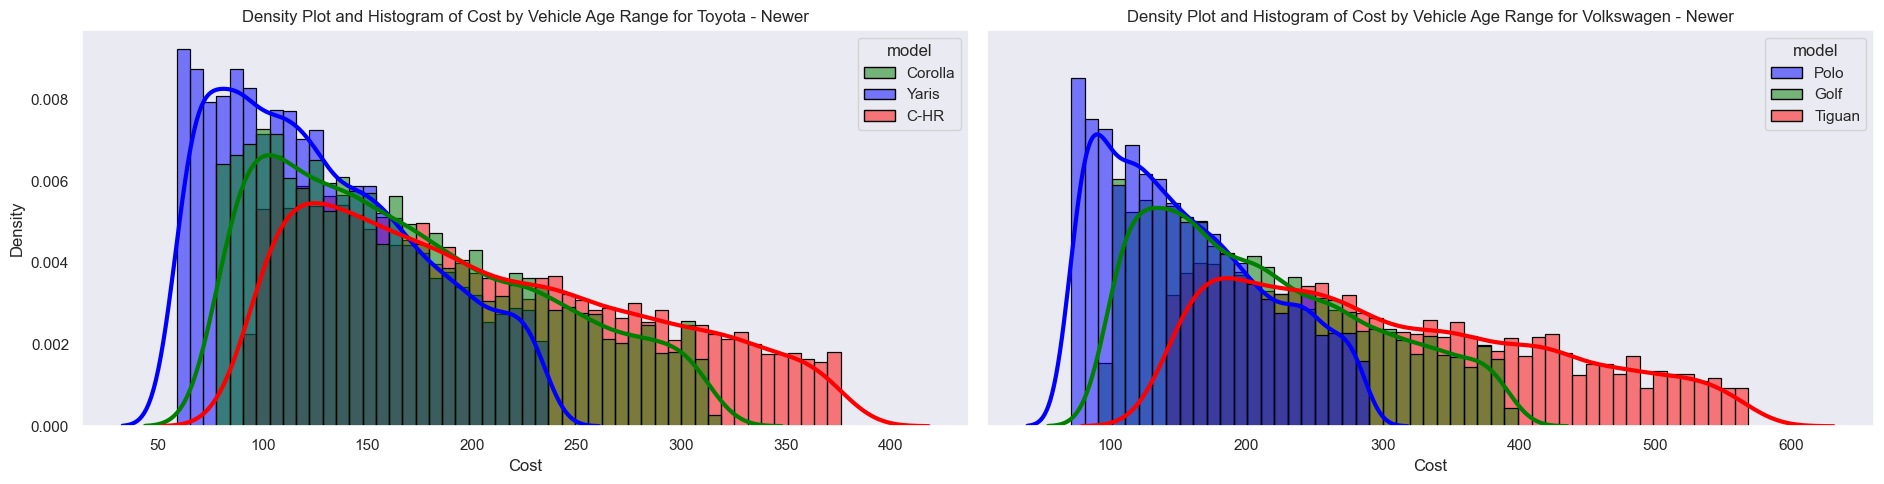

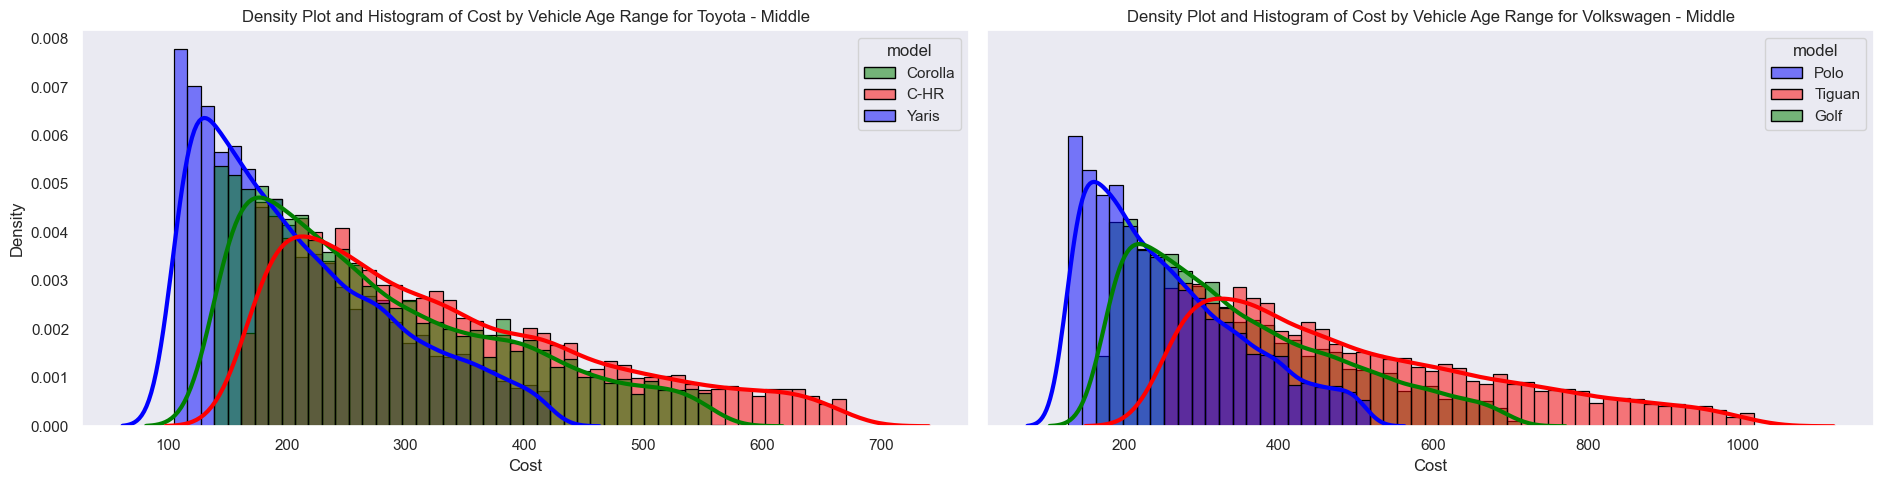

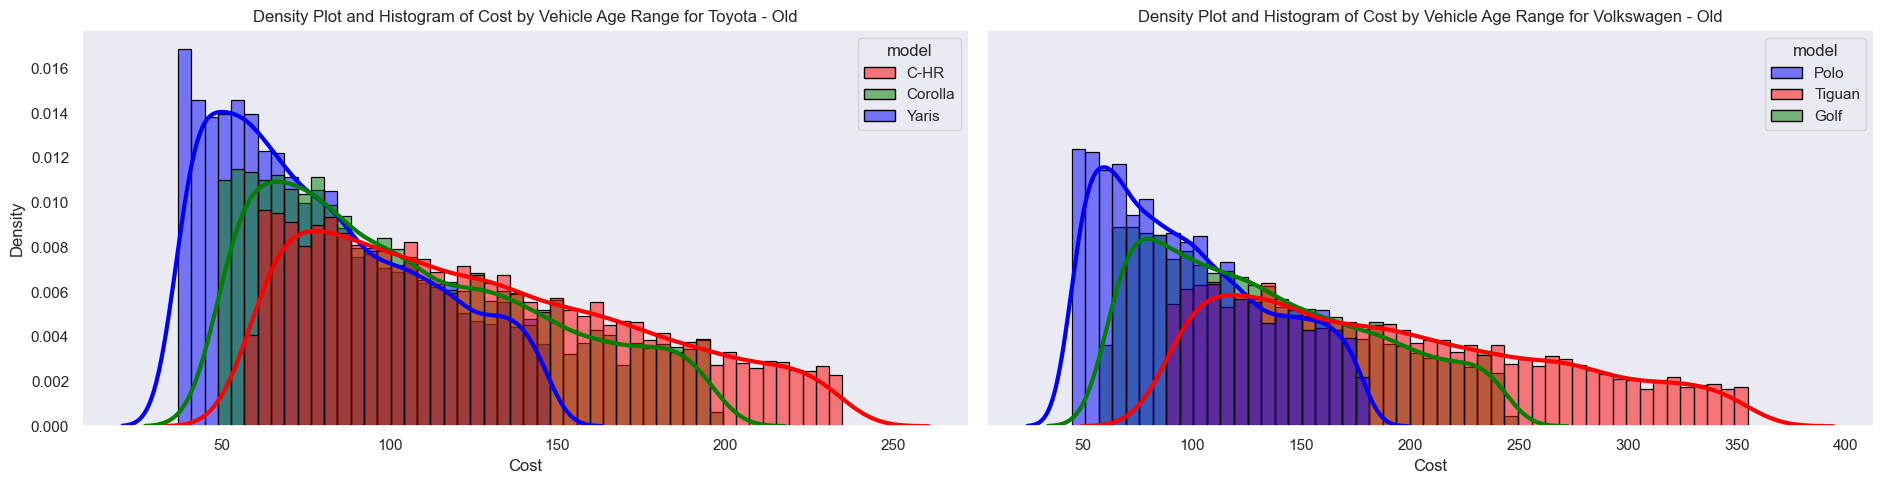

Summary statistics by brand, model, and vehicle age range:
                                  mean  std  min  25%  50%  75%   max
brand      model   veh_age_range                                     
Toyota     Yaris   Newer           128   47   59   88  120  162   235
                   Middle          207   79  105  140  188  259   420
                   Old              79   30   37   54   74  102   147
           Corolla Newer           169   63   78  115  159  217   314
                   Middle          277  107  140  188  250  351   559
                   Old             105   40   49   71   98  135   196
           C-HR    Newer           205   77   94  138  191  263   376
                   Middle          333  128  168  227  302  415   671
                   Old             127   47   59   86  119  162   235
Volkswagen Polo    Newer           155   59   72  104  145  198   286
                   Middle          253   97  128  173  231  315   510
                   Old         

In [12]:
cost_analysis(df_repair_glass_crack, models)

**Labour Cost**

To decide how much time it should take to repart a windscreen we are basing it on the following [source](https://www.autoglass.ie/top-5-myths-windscreen-repair/#:~:text=Repairs%20can%20take%20as%20little,repair%20misconceptions%20laid%20to%20rest.). As such, from 0.5 to 2 hours.

                      count   mean    std   min    25%    50%   75%     max
num_hours           90000.0   0.64   0.14   0.5   0.54   0.60   0.7    2.05
labour_costs        90000.0  62.86  21.72  33.6  46.20  60.00  66.0  112.20
total_labour_costs  90000.0  40.39  16.90  16.8  28.71  35.44  48.6  203.90


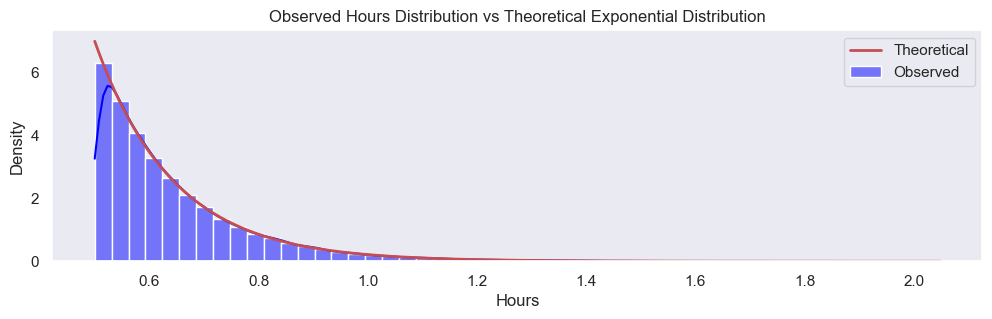

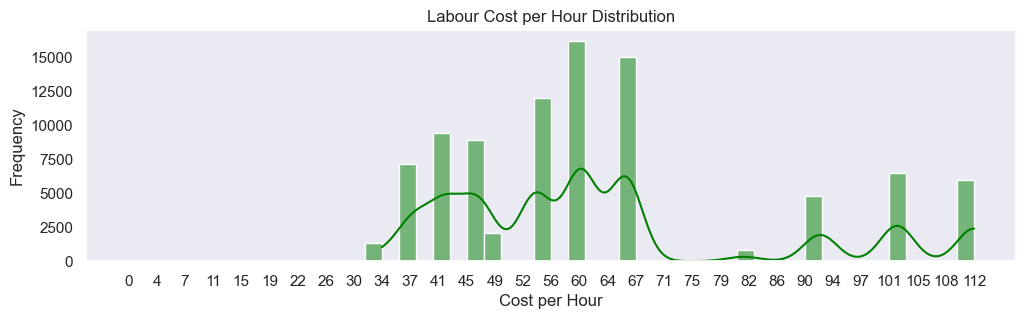

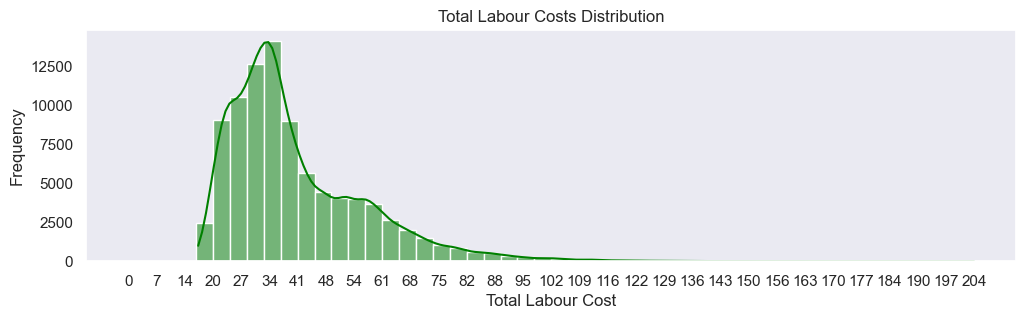

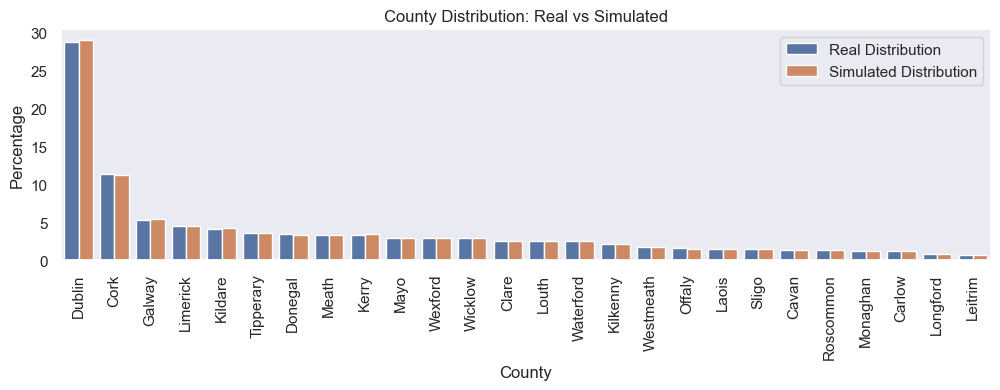

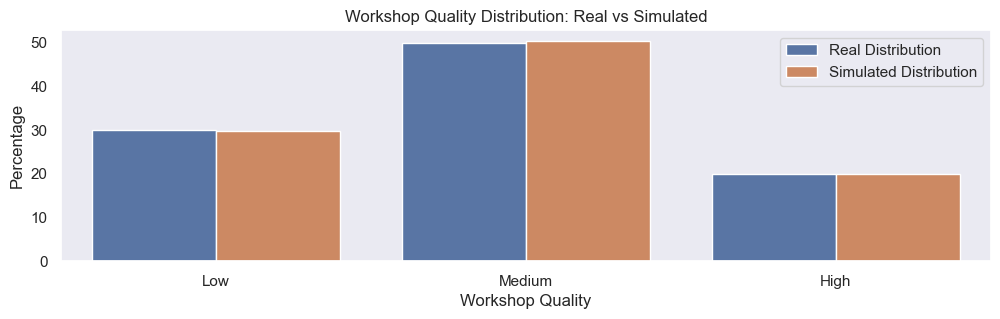

In [158]:
lmbda=7
df_labour_glass_crack = simulate_labour(n=90000, lmbda=lmbda,ini=0.5)
labour_analysis(df_labour_glass_crack,lmbda=lmbda,ini=0.5)

**Total Cost**

In [193]:
df_total_glass_crack = conc_total_cost(df_repair_glass_crack, df_labour_glass_crack)
print(df_total_glass_crack.head())

        brand    model veh_age_range workshop_quality counties  damage_type  \
0  Volkswagen     Polo         Newer           Medium   Dublin  glass_crack   
1      Toyota     C-HR           Old             High    Cavan  glass_crack   
2      Toyota  Corolla        Middle           Medium    Louth  glass_crack   
3  Volkswagen     Polo        Middle             High   Dublin  glass_crack   
4  Volkswagen     Golf         Newer              Low   Dublin  glass_crack   

   repair_cost  labour_cost  total_cost  
0       197.22        35.99      233.21  
1       124.22        48.37      172.59  
2       163.60        39.13      202.73  
3       194.94        97.00      291.94  
4       103.56        35.08      138.64  


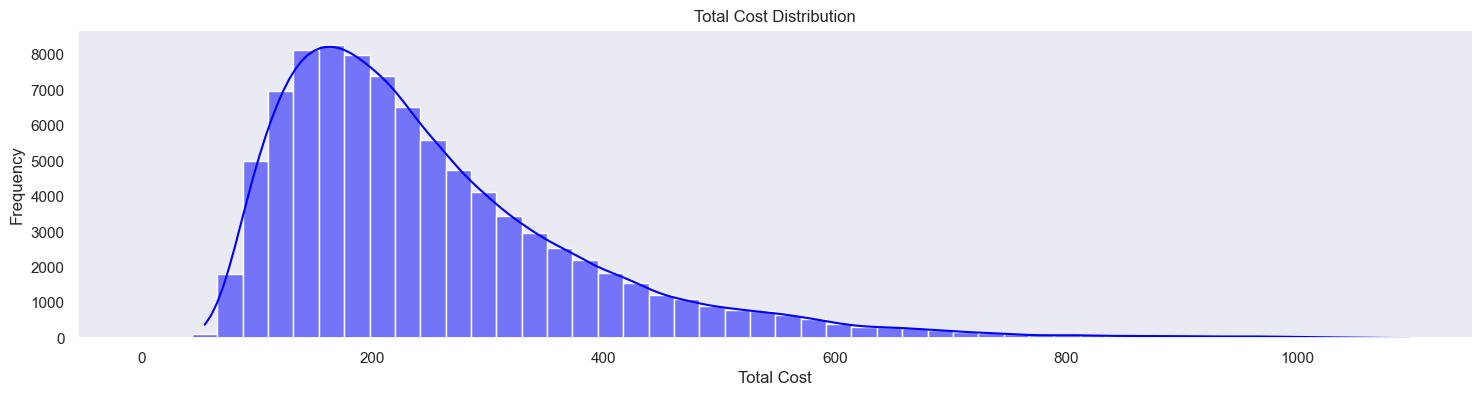

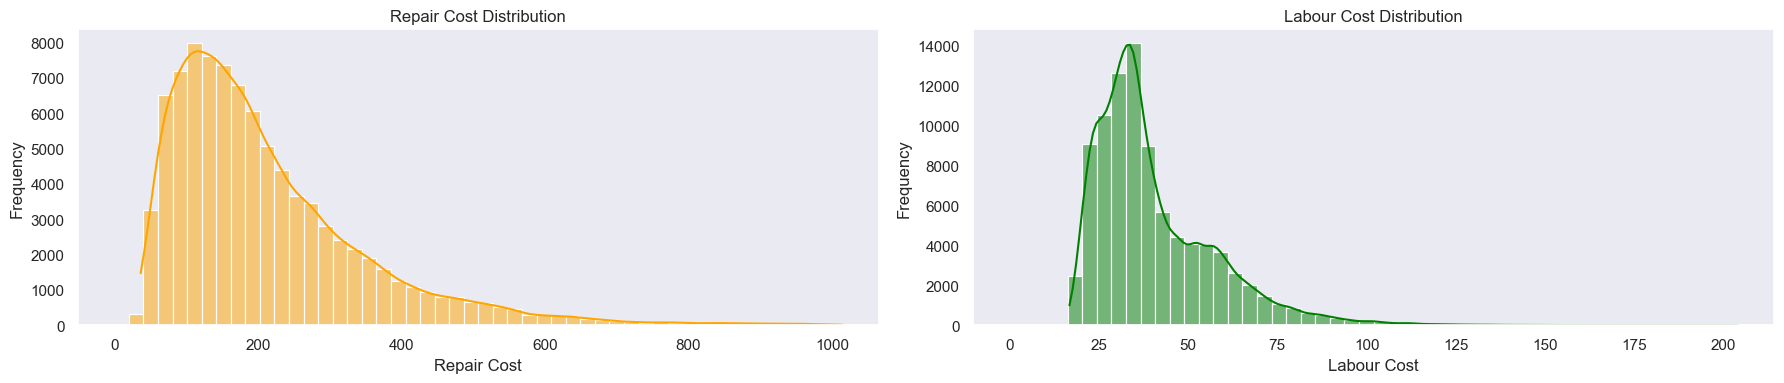

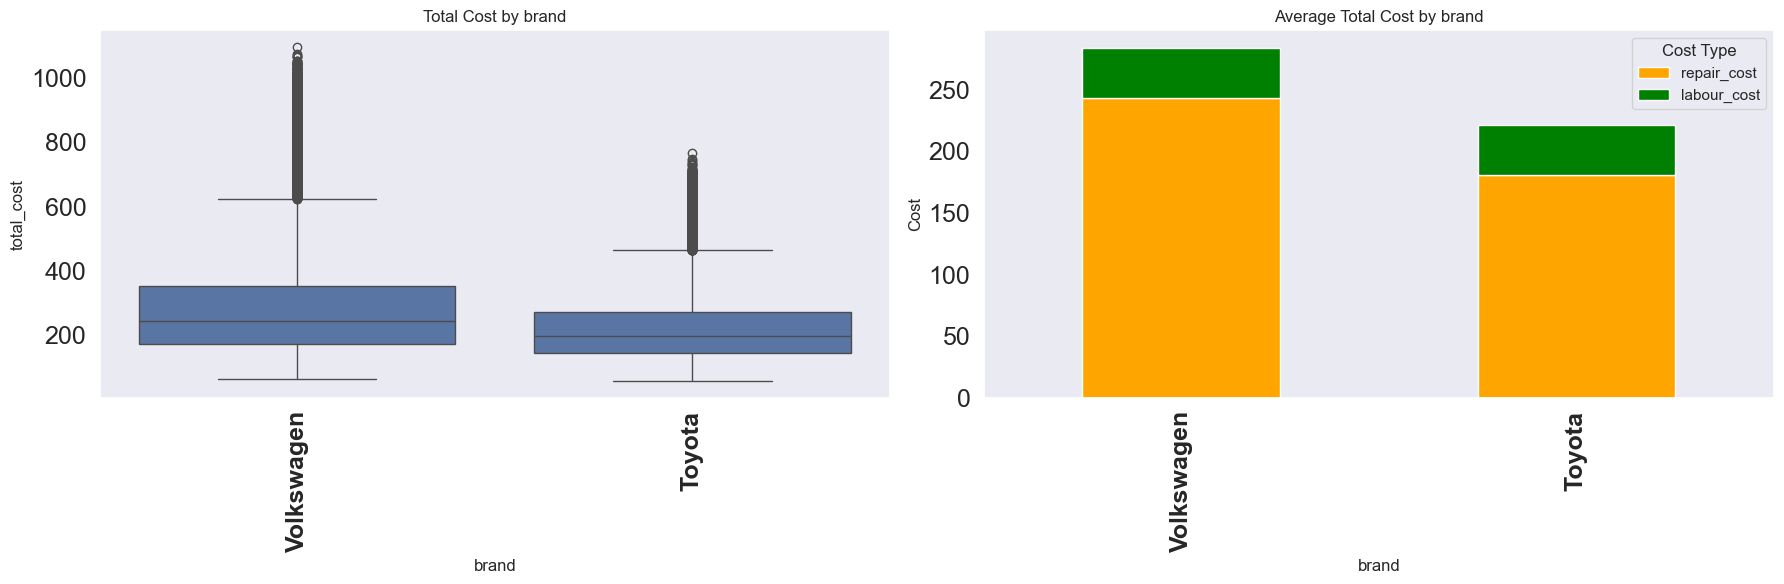

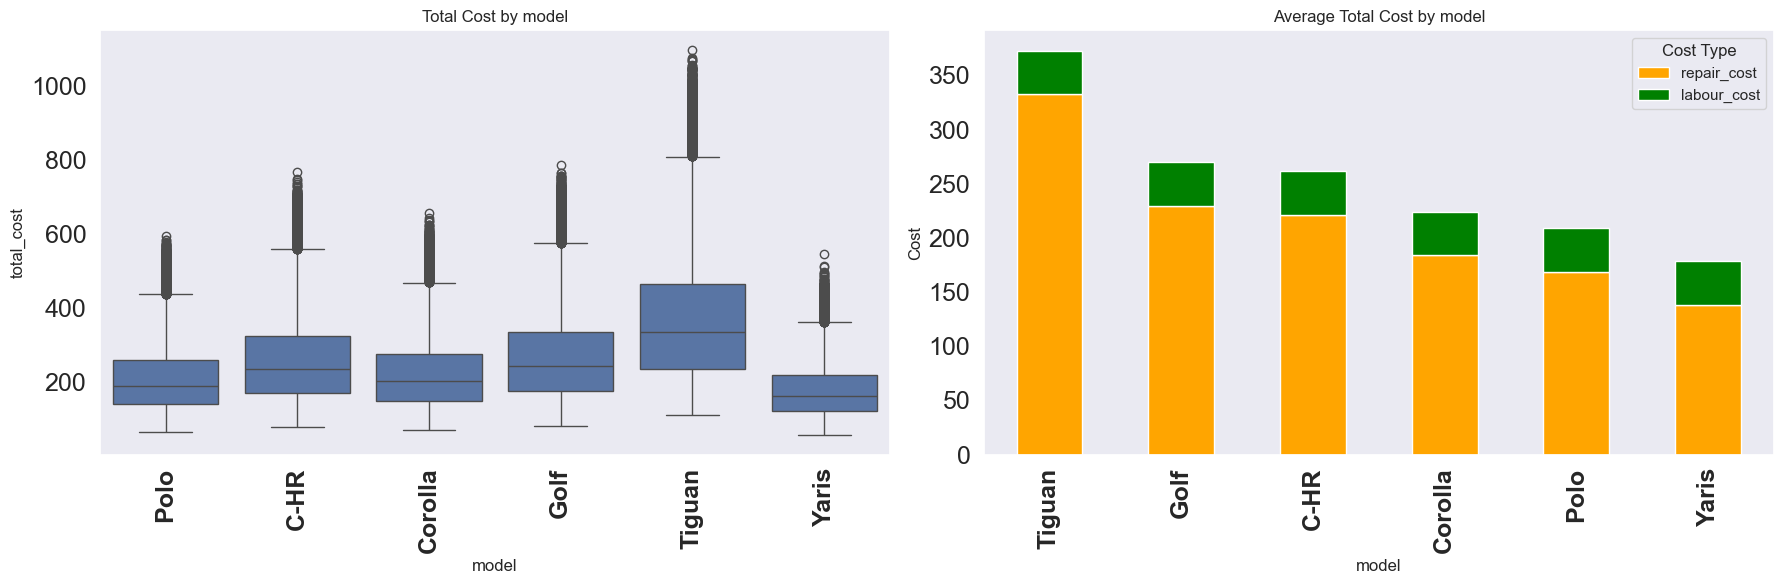

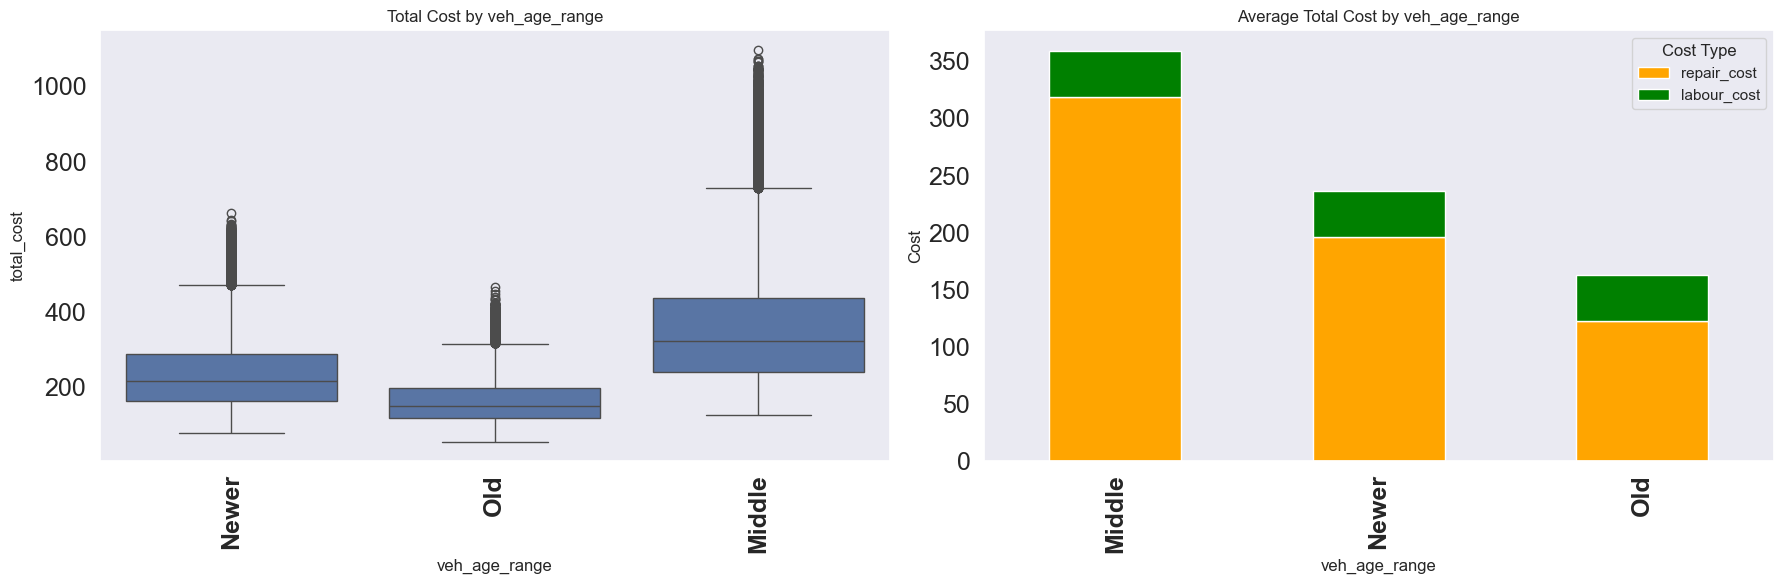

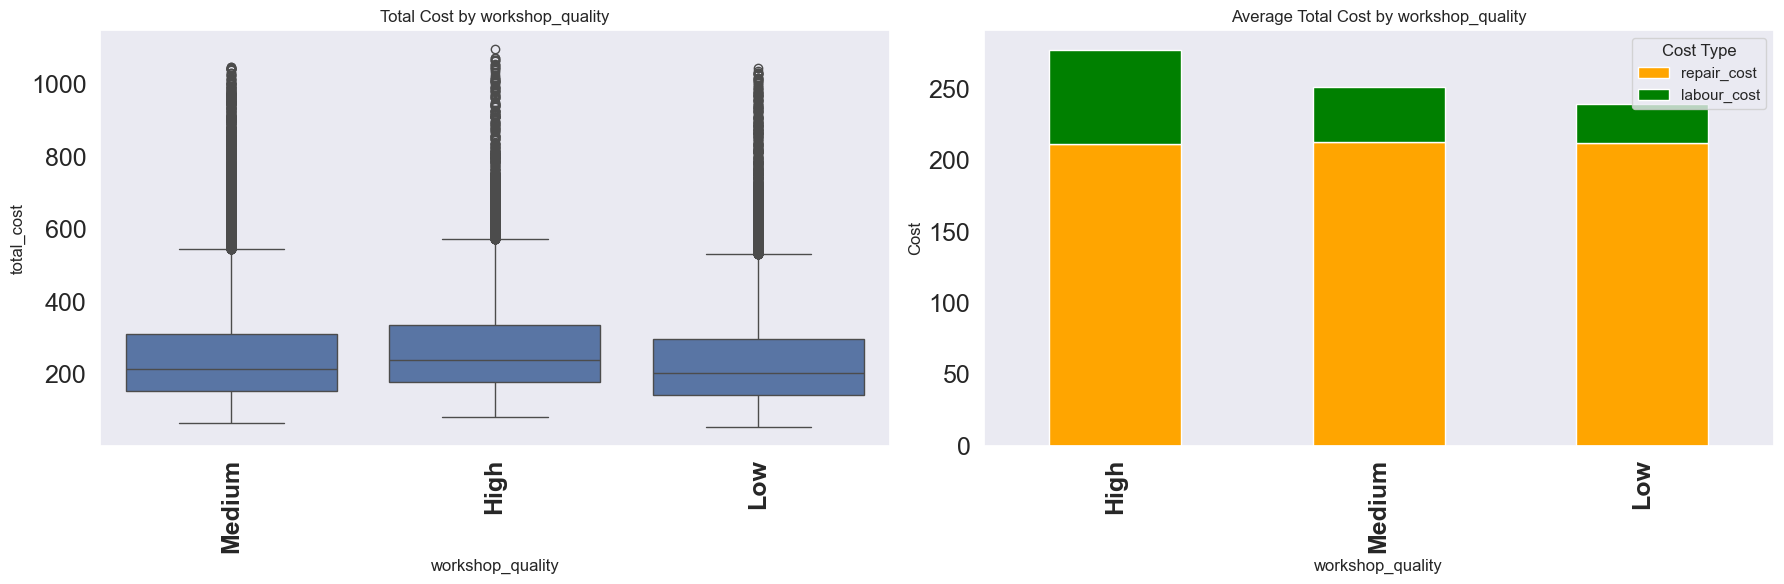

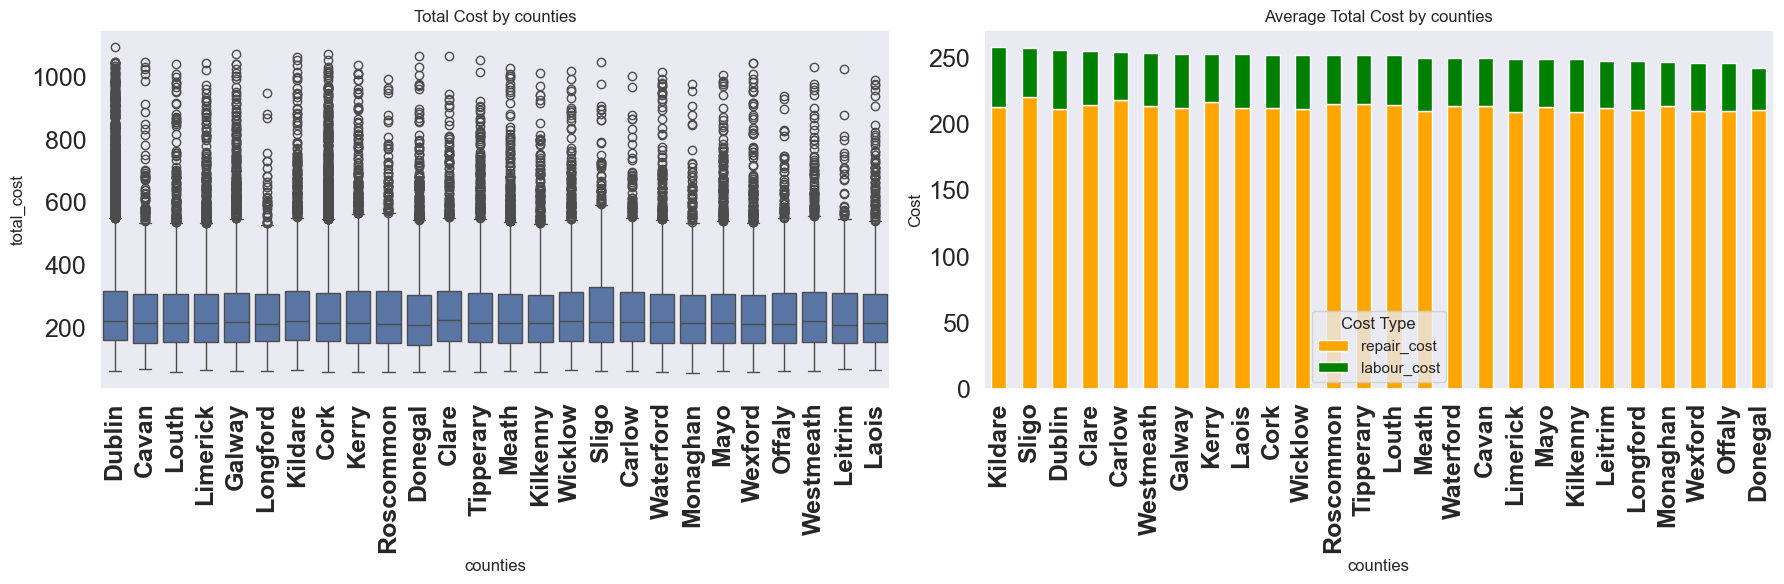

In [194]:
analysis_total_cost(df_total_glass_crack)

### <font color="#62b6cb">1.5 Miscellaneous Damage - puncture (mis_punct)</font> <a name="id15"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.6 Miscellaneous Damage - broken lamp (mis_lamp)</font> <a name="id16"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.7 Metal damage dent - minor dented (met_dent_minor)</font> <a name="id17"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.8 Metal damage dent - medium dented (met_dent_medium)</font> <a name="id18"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.9 Metal damage dent - severe dented (met_dent_severe)</font> <a name="id19"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

For defining the repairs costs distribution of this damage type, we have looked into the following webpages:
* [airtasker](https://www.airtasker.com/ie/costs/windscreen-repair-replacement/cost-of-windscreen-repairs-and-replacement/)

It states that in general prices go from €100 to €380 with a median of €200.

### <font color="#62b6cb">1.10 Total Cost Dataset</font> <a name="id110"></a>

## <font color="#62b6cb"> 2. Cost Model <a name="id2"></a>

+ Take the database a shuffle the observations using 123 seed 
+ Split Train and test
+ lasso regression or ridge regression?
+ gamma link function as it is and average cost model?
+ no splines because they are categorical variables?
+ for counties check the absolute value of training observations for and the average cost - chart of how it is distributed
+ Take all the variables because we know all of them are relevant
+ get the MSE but also the Emblem backtesting calculation
+ look again how to save the model and store it and in another one run it
